In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
import spacy
import itertools

In [140]:
test = pd.read_csv(r'data\BBC News Test.csv')
train = pd.read_csv(r'data\BBC News Train.csv')

## EDA

In [114]:
# Look at a same text val
train.sample(1)['Text'].values

array(['actor   find gun residue   actor robert blake gunshot residue hand clothe night wife shoot dead   court hear   come shot kill bonny lee bakley   mr blake s murder trial tell criminalist steven dowell mr dowell tell los angeles court residue come mr blake s revolver   gun collection   presence crime scene police year old star tv drama baretta deny murder mr blake say find ms bakley     dead car leave restaurant   say briefly return restaurant collect gun leave discover body return gun collect murder weapon pick touch lean car find body   police box clothe later store box come area officer go firing range mr dowell say residue present mr blake fire gun night witness tell trial mr blake   stand nervous agitated   restaurant murder actor   win emmy play maverick detective 1970s tv cop drama baretta   face life prison convict'],
      dtype=object)

Looking at the number of categories shows that there aren't any obvious undersampled ones

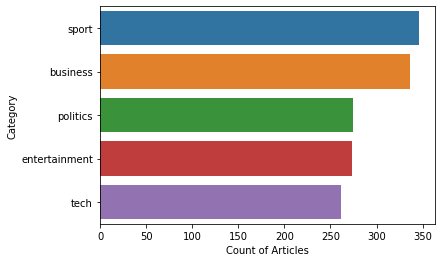

In [9]:
sns.barplot(data=train['Category'].value_counts().to_frame().reset_index(),
            x='Category',
            y='index')
plt.ylabel('Category')
plt.xlabel('Count of Articles')
plt.show()

Further looking at the distribution of word count for categories

In [10]:
train['NumberOfWords'] = train['Text'].str.split().apply(len)

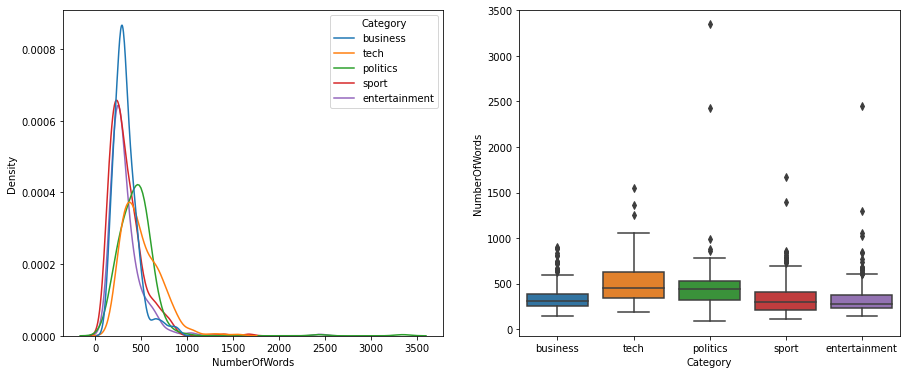

In [11]:
figs, axs = plt.subplots(ncols=2,
                        figsize=(15,6))

g1 = sns.kdeplot(data=train,
        x='NumberOfWords',
        hue='Category',
           ax=axs[0])

g2 = sns.boxplot(data=train,
            x='Category',
            y='NumberOfWords',
           ax=axs[1])

### Lemmatize and remove stop words using spacy

Some stop words such as 'the', 'if' etc do not provide any classification value, these can be removed along with numbers and punctuation text.

In [12]:
#Load a medium trained model
nlp = spacy.load("en_core_web_md")

In [13]:
def cleaner(note):
    """Remove stop words, punctuations, convert words into lemma_"""
    doc = nlp(note)
    return (" ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]))

In [15]:
# Might take a while to run this (around 2 mins)
train['Text'] = train['Text'].astype(str).apply(cleaner)

## Unsupervised Model (NMF)

To generate our text document, we first get word counts and then calculate their tf-dif (term frequency-inverse document frequency) that will be passed onto our model

In [73]:
counter = CountVectorizer()
bag = counter.fit_transform(train['Text'].values)

In [74]:
# Bag contains a sparse matix of all document, word combinations as a 1-gram model (broken off by single words)
bag.toarray().shape

(1490, 18778)

In [75]:
# Apply tf-idf technique to weight down frequent words appearing in all docs
tfidf_vec = TfidfTransformer(use_idf=True,
                            norm='l2', # Apply l2 normalization 
                            smooth_idf=True) # Assigns zero weights to terms occuring in all dosc

In [78]:
tfidf_run = tfidf_vec.fit_transform(bag)

We can use grid search for tfidft and nmf parameters to tune the model, for this project we only did some ad-hoc changes and went with an NMF model using frobenius beta_loss

In [121]:
nmf = NMF(n_components=5, # The number of topics we want
          beta_loss='frobenius', # 
          random_state=42)

In [122]:
nmf.fit(tfidf_run)

NMF(n_components=5, random_state=42)

In [123]:
nmf.transform(tfidf_run)

array([[0.00295889, 0.04395665, 0.01460197, 0.00496339, 0.03781248],
       [0.        , 0.        , 0.        , 0.        , 0.21268833],
       [0.01834963, 0.03409397, 0.01864832, 0.        , 0.12073696],
       ...,
       [0.01129713, 0.00116399, 0.00237153, 0.01236777, 0.16039821],
       [0.        , 0.        , 0.22233099, 0.00404614, 0.01708015],
       [0.00119551, 0.        , 0.106077  , 0.        , 0.00233523]])

In [124]:
# We can get the max position of the transform using argmax
predicted_labels = nmf.transform(tfidf_run).argmax(axis=1)
predicted_labels

array([1, 4, 4, ..., 4, 2, 2], dtype=int64)

In [125]:
def label_permute_compare(y_actual, y_pred, n=5):
    """
    Args:
        y_actual -> pd.Series with categories as text
        y_pred -> np.array with predictions
        n -> Number of permutations in y_pred 
    Returns: 
        Predicted labels, accuracy score
    """
    all_scores = []
    actual_labels = y_actual.unique().tolist()
    
    # Generate permutations to check against
    for perm in itertools.permutations((0, 1, 2, 3, 4), 5):
        remap_dict = dict(zip(actual_labels, perm))
        # Change the values in the prediction
        y_actual_coded = y_actual.replace(remap_dict)
        acc = accuracy_score(y_actual_coded, y_pred)           
        all_scores.append([perm, acc])
    
    best_score = sorted(all_scores, key=lambda x:x[1])[-1]
    
    return best_score, actual_labels

In [126]:
# We pass the max values into a function to predict the labels
label_predictions = label_permute_compare(train['Category'], predicted_labels)

# Print the results
print(f'Labels are -> {label_predictions[0][0]} for {label_predictions[1]}\
\n Accuracy -> {label_predictions[0][1]}')

Labels are -> (4, 2, 1, 0, 3) for ['business', 'tech', 'politics', 'sport', 'entertainment']
 Accuracy -> 0.9201342281879195


In [131]:
label_category_mapping = dict(zip(label_predictions[0][0], label_predictions[1]))
label_category_mapping

{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}

In [132]:
train_results = train.copy().assign(Predictions=list(map(label_category_mapping.get, predicted_labels)))
train_results.sample(20)

,ArticleId,Text,Category,NumberOfWords,Predictions
107,1843,mitsubishi peugeot link talk trouble hit mitsu...,business,163,business
616,110,web radio take spanish rap global spin radio d...,tech,710,tech
895,2197,gm issue profit warn general motors warn expec...,business,303,business
1118,1112,eu referendum question unveil question ask ref...,politics,550,politics
614,11,berlin cheer anti nazi film german movie anti ...,entertainment,307,entertainment
993,2045,kennedy begin pre election tour liberal democr...,politics,411,politics
1192,1388,parker s saxophone head auction saxophone belo...,entertainment,201,entertainment
177,1205,glance tory health check uk opposition conse...,politics,552,politics
501,356,eu slow economic reform eu country fail pl...,business,253,business
848,487,kennedy look election gain know describe posit...,politics,551,politics


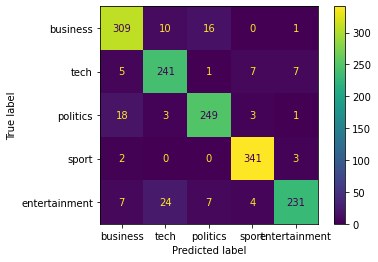

In [133]:
cf_m = ConfusionMatrixDisplay(confusion_matrix(train_results['Category'], 
                                               train_results['Predictions'],
                                               labels=label_predictions[1]),
                                               display_labels=label_predictions[1])
cf_m.plot()

### Test Predictions

In [69]:
# Spacy to clean text
test['Text'] = test['Text'].astype(str).apply(cleaner)

KeyboardInterrupt: 

In [134]:
bag_test = counter.transform(test['Text'].values)

In [135]:
tfidf_test_run = tfidf_vec.transform(bag_test)

In [136]:
# We can get the max position of the transform using argmax
test_predicted_labels = nmf.transform(tfidf_test_run).argmax(axis=1)
test_predicted_labels

array([0, 2, 0, 4, 0, 0, 1, 1, 3, 4, 4, 2, 1, 2, 3, 0, 1, 2, 3, 2, 4, 1,
       0, 4, 1, 0, 4, 0, 0, 4, 1, 3, 4, 4, 0, 0, 0, 4, 3, 4, 1, 1, 3, 2,
       0, 2, 3, 4, 1, 4, 1, 4, 4, 4, 2, 1, 2, 3, 0, 2, 0, 3, 2, 1, 4, 3,
       0, 2, 0, 0, 2, 0, 4, 1, 2, 0, 2, 2, 2, 3, 1, 0, 3, 0, 4, 3, 4, 3,
       4, 2, 4, 1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 4, 3, 4, 0, 1, 0, 1, 3,
       0, 4, 3, 0, 1, 0, 1, 0, 1, 4, 3, 4, 3, 2, 2, 0, 4, 3, 4, 3, 4, 1,
       1, 2, 4, 4, 1, 2, 3, 0, 4, 2, 0, 3, 4, 0, 0, 3, 3, 2, 4, 2, 1, 3,
       0, 0, 0, 0, 3, 0, 4, 2, 4, 2, 4, 2, 3, 2, 2, 1, 4, 1, 4, 4, 3, 1,
       2, 4, 4, 2, 0, 1, 3, 1, 2, 2, 1, 4, 1, 2, 1, 4, 3, 0, 0, 2, 4, 2,
       1, 4, 0, 1, 4, 3, 4, 4, 0, 2, 4, 0, 3, 3, 0, 3, 0, 2, 4, 3, 0, 3,
       0, 3, 1, 4, 2, 3, 4, 1, 1, 2, 4, 0, 1, 1, 4, 1, 0, 4, 3, 1, 0, 1,
       4, 0, 2, 4, 1, 4, 1, 4, 4, 0, 2, 1, 3, 2, 3, 2, 0, 0, 2, 0, 0, 0,
       3, 0, 1, 0, 4, 0, 4, 0, 4, 0, 2, 4, 4, 3, 1, 4, 0, 0, 2, 0, 0, 3,
       4, 0, 2, 1, 3, 4, 4, 1, 0, 3, 1, 4, 0, 0, 2,

In [137]:
test_results = test.copy().assign(Category=list(map(label_category_mapping.get, test_predicted_labels)))
test_results.sample(20)

,ArticleId,Text,Category
350,1601,savvy searcher fail spot ad internet search en...,tech
106,1258,blair face mps amid feud talk tony blair face ...,politics
358,1663,delta cut fare survival plan delta air line cu...,business
446,963,german music zombie state german music bus...,tech
437,961,fed warn rate rise look set continued boost in...,business
399,1324,baby new oscar favourite clint eastwood s boxi...,entertainment
494,713,blue beat u2 france honour irish band u2 honou...,entertainment
471,621,israel look bank chief israel ask banker inter...,business
361,1010,cardinal criticise iraq war cost billion pound...,politics
452,2005,johansson take adelaide victory seed joachim j...,sport


In [138]:
test_results[['ArticleId', 'Category']].to_csv('predictions\unsupervised_predictions.csv', index=False)

The unsupervised test public score was 0.92789

## Supervised Model

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfidf_run.toarray(), train['Category'])

In [39]:
category_predictions = knn.predict(tfidf_run.toarray())

In [40]:
accuracy_score(train['Category'], category_predictions)  

0.9557046979865772

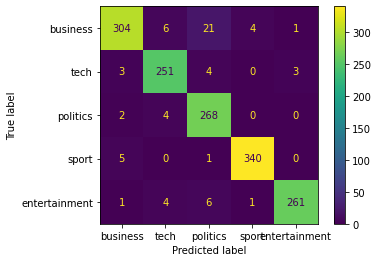

In [139]:
cf_m_sup = ConfusionMatrixDisplay(confusion_matrix(train['Category'], 
                                                   category_predictions,
                                                   labels=label_predictions[1]),
                                                   display_labels=label_predictions[1])
cf_m_sup.plot()

### Tests Predictions

In [105]:
test_category_predictions = knn.predict(tfidf_test_run.toarray())

In [108]:
test_results_supervised = test.copy().assign(Category=test_category_predictions)
test_results_supervised.sample(20)

,ArticleId,Text,Category
313,498,putin back state grab yukos russia s president...,business
142,472,parry put gerrard money listen interview s...,sport
223,296,bush outline tough budget president bush s...,business
361,1010,cardinal criticise iraq war cost billion pound...,politics
74,608,swap offer pirate window xp computer giant mic...,tech
272,1242,indonesians face fuel price rise indonesia s g...,business
107,721,hansen delay return british triple jumper ...,sport
458,1448,trial begin spain s banker trial emilio botin ...,business
352,1296,manchester win labour conference labour party ...,politics
500,501,global digital divide narrow digital div...,politics


In [141]:
test_results_supervised[['ArticleId', 'Category']].to_csv('predictions\supervised_predictions.csv', index=False)

The unsupervised test public score was 0.94829

## References


<br>Competition https://kaggle.com/competitions/learn-ai-bbc</br>
<br>Sklearn Library https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html</br>
<br>Spacy https://spacy.io/usage/spacy-101</br>
<br>ML Book https://github.com/rasbt/machine-learning-book</br>